In [1]:
import pandas as pd

In [2]:
lat_CHC = -16.35
lon_CHC = -68.13
lat_ATTO = -2.1457
lon_ATTO = - 59.0048
_dic = dict(Amazon={'lat': lat_ATTO, 'lon': lon_ATTO},
            Chacataya={'lat':lat_CHC, 'lon':lon_CHC}
           )
collocate_locations = pd.DataFrame.from_dict(_dic)
collocate_locations

,Amazon,Chacataya
lat,-2.1457,-16.35
lon,-59.0048,-68.13


In [3]:
from sect_sens.util.Nd.sizedist_class_v2 import SizedistributionSurface, SizedistributionStation

/home/ubuntu/mnts/nird/projects/SECT_SENS/sect_sens/data_info/area_defs.csv
/home/ubuntu/mnts/nird/projects/SECT_SENS/sect_sens/data_info/


In [4]:
from sect_sens.util.plot import plot_profiles

from sect_sens.util.naming_conventions import var_info

from sect_sens.util.imports import get_averaged_fields

from IPython import get_ipython
from useful_scit.imps import (plt)
from matplotlib.lines import Line2D
import seaborn as sns

from sect_sens.data_info.simulation_types import get_diff_by_type, get_casen_by_type_mod
from sect_sens.util.imports import get_averaged_fields
from sect_sens.util.naming_conventions.var_info import get_fancy_var_name, get_fancy_unit_xr
from sect_sens.util.plot.colors import get_case_col
from sect_sens.util.plot.plot_maps import plot_map_diff, plot_map

from sect_sens.constants import get_plotpath, path_data_info
from sect_sens.util.practical_functions import make_folders
import cartopy.crs as ccrs
from matplotlib import gridspec
from matplotlib import colors

# noinspection PyBroadException
try:
    _ipython = get_ipython()
    _magic = _ipython.magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
p_level = 1013.
pmin = 850.  # minimum pressure level
avg_over_lev = True  # True#True#False#True
pressure_adjust = True  # Can only be false if avg_over_lev false. Plots particular hybrid sigma lev
p_levels = [1013., 900., 800., 700., 600.]  # used if not avg

In [6]:
model = 'NorESM'

startyear = '0004-01'
endyear = '0008-12'

In [7]:
model = 'NorESM'

startyear = '2008-01'
endyear = '2014-12'

## Cases

In [8]:
cases_sec = [
    'SECTv21_ctrl_koagD',
    #'NF1850_SECT_ctrl',
    #'NF1850_SECT_gord',
    #'NF1850_aeroxid2014_SECT_ctrl',
    #'NF1850_aeroxid2014_SECT_gord'
]
cases_orig = [
    #'NF1850_noSECT_def',
    'noSECTv21_default_dd',
    'noSECTv21_ox_ricc_dd',
    
#    'NF1850_aeroxid2014_noSECT_def',
#    'NF1850_aeroxid2014_noSECT_ox_ricc',
    #'NF1850_noSECT_ox_ricc',
    #'NF1850_noSECT_ox_gord',
    #'NF1850_aeroxid2014_noSECT_ox_ricc_test_gordon',
]

cases_pd = cases_orig + cases_sec

## Cases

In [9]:
cases = cases_pd #+ cases_pi

In [10]:
from pathlib import Path

In [11]:
version = 'pd_amazon_chc'
plot_path = get_plotpath('measurement_comp')
filen_base = Path(plot_path + '/%s' % version)
filen_base.mkdir(exist_ok=True)
# print(plot_path)
make_folders(plot_path)

In [12]:
from sect_sens.util.slice_average.avg_pkg import yearly_mean_dic

In [13]:
varl = ['NCONC01','N50','N60','Z3']#,'N60']

In [14]:
cases

['noSECTv21_default_dd', 'noSECTv21_ox_ricc_dd', 'SECTv21_ctrl_koagD']

In [15]:
from sect_sens.util.collocate.collocate import CollocateModel

In [16]:
from sect_sens.data_info.variable_info import sized_varListNorESM,sized_varlist_SOA_SEC, sized_varlist_SO4_SEC

In [17]:
vl = sized_varListNorESM['NCONC']+sized_varListNorESM['NMR']+ sized_varListNorESM['SIGMA']

In [18]:
vl_sec = sized_varlist_SO4_SEC + sized_varlist_SOA_SEC

## Create collocated datasets:

In [19]:
dic_collds = {}

In [20]:
for case in cases_pd:
    print(case)
    _vl = vl
    isSec = (case in cases_sec)
    if isSec:
        _vl = vl + vl_sec
    collmod = CollocateModel(case,
                             startyear, 
                             endyear,
                             isSec,
                             'month',
                             space_res='locations',
                             locations = collocate_locations
               #[5,39.6],
               #False,
              )
    collmod.locations = collocate_locations
    try:
        _ds = collmod.collocate_dataset_vars(_vl)
    except:
        collmod.load_raw_ds(_vl)
        _ds = collmod.collocate_dataset_vars(_vl)
    dic_collds[case] = _ds#.copy()
#collmod.get

noSECTv21_default_dd
noSECTv21_ox_ricc_dd
SECTv21_ctrl_koagD


In [21]:
import xarray as xr

In [22]:
dic_sdist = {}
dic_ds={}

for case in cases_pd:
    print(case)
    _vl = vl
    isSec = (case in cases_sec)
    if isSec:
        _vl = vl + vl_sec
    sdist = SizedistributionStation.SizedistributionStation(
        case,
        startyear, 
        endyear,
        [5,39.6],
        isSec,
        'month',
        locations=collocate_locations,
        
    )
    sdist.get_collocated_dataset(vl)
    
    ds = sdist.compute_sizedist_tot()
    for var in ['dNdlogD_mode01','dNdlogD_mode04','dNdlogD_mode02',
            'dNdlogD_mode05','dNdlogD_mode06','dNdlogD_mode07',
            'dNdlogD_mode08','dNdlogD_mode09','dNdlogD_mode10'
           ,'dNdlogD_mode12','dNdlogD_mode14']:
        ds[var] = sdist.compute_sizedist_mod_var(var)[var]
    dic_ds[case] = ds.copy()
    dic_sdist[case] = sdist

noSECTv21_default_dd
['NCONC01', 'NCONC02', 'NCONC04', 'NCONC05', 'NCONC06', 'NCONC07', 'NCONC08', 'NCONC09', 'NCONC10', 'NCONC12', 'NCONC14', 'NMR01', 'NMR02', 'NMR04', 'NMR05', 'NMR06', 'NMR07', 'NMR08', 'NMR09', 'NMR10', 'NMR12', 'NMR14', 'SIGMA01', 'SIGMA02', 'SIGMA04', 'SIGMA05', 'SIGMA06', 'SIGMA07', 'SIGMA08', 'SIGMA09', 'SIGMA10', 'SIGMA12', 'SIGMA14']
/home/ubuntu/mnts/nird/projects//Output_data_SECT_SENS//collocated_ds//NorESM/noSECTv21_default_dd/NCONC01_noSECTv21_default_dd_2008-01_2014-12_month_locations.nc
/home/ubuntu/mnts/nird/projects//Output_data_SECT_SENS//collocated_ds//NorESM/noSECTv21_default_dd/NCONC02_noSECTv21_default_dd_2008-01_2014-12_month_locations.nc
/home/ubuntu/mnts/nird/projects//Output_data_SECT_SENS//collocated_ds//NorESM/noSECTv21_default_dd/NCONC04_noSECTv21_default_dd_2008-01_2014-12_month_locations.nc
/home/ubuntu/mnts/nird/projects//Output_data_SECT_SENS//collocated_ds//NorESM/noSECTv21_default_dd/NCONC05_noSECTv21_default_dd_2008-01_2014-12_mont

In [23]:
import xarray as xr

(0.1, 5000.0)

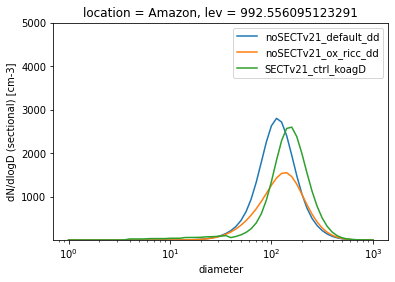

In [24]:
yscale = 'linear'

for case in cases_orig:
    ds= dic_ds[case]
    ds['dNdlogD_mod'].isel(location=1,lev=-5).mean('time').plot(xscale='log', yscale=yscale, label=case)
for case in cases_sec:
    ds= dic_ds[case]
    (ds['dNdlogD_sec']+ds['dNdlogD_mod']).isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale=yscale, label=case)
plt.legend()
plt.ylim([1e-1,5e3])

In [25]:
import numpy as np

(10.0, 500.0)

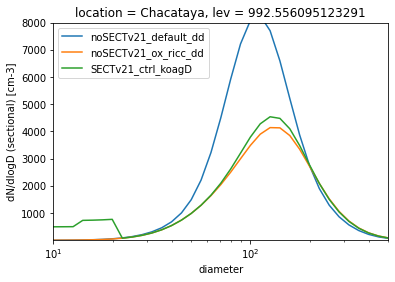

In [26]:
yscale = 'linear'

for case in cases_orig:
    ds= dic_ds[case]
    (ds['dNdlogD_mod']*np.log(10)).isel(location=1,lev=-1).mean('time').plot(xscale='log', yscale=yscale, label=case)
for case in cases_sec:
    ds= dic_ds[case]
    ((ds['dNdlogD_sec']+ds['dNdlogD_mod'])*np.log(10)).isel(location=1,lev=-1).mean('time').plot(xscale='log', yscale=yscale, label=case)
plt.legend()
plt.ylim([1e1,8e3])
plt.xlim([1e1,5e2])

In [27]:
from useful_scit.imps import *

In [28]:
from sect_sens.constants import project_base_path, project_name
from pathlib import Path

In [29]:
base_dir = Path(project_base_path+project_name)

In [30]:
path_data = base_dir /'data/EBAS'
path_data.exists()

True

In [31]:
fl = list(path_data.glob('*.1y.*.nc'))

In [32]:
fl

[PosixPath('/home/ubuntu/mnts/nird/projects/SECT_SENS/data/EBAS/BO0001R.20150101000000.20190917175550.smps.particle_number_size_distribution.aerosol.1y.1h.BO01L_SMPS_UMSA-LAP_CHACALTAYA_BOLIVIA.DE08L_TROPOS_CL_SMPS.lev2.nc'),
 PosixPath('/home/ubuntu/mnts/nird/projects/SECT_SENS/data/EBAS/BO0001R.20190101000000.20200402012333.smps.particle_number_size_distribution.aerosol.1y.1h.BO01L_SMPS_UMSA-LAP_CHACALTAYA_BOLIVIA.DE08L_TROPOS_CL_SMPS.lev2.nc'),
 PosixPath('/home/ubuntu/mnts/nird/projects/SECT_SENS/data/EBAS/BO0001R.20170101000000.20190917180155.smps.particle_number_size_distribution.aerosol.1y.1h.BO01L_SMPS_UMSA-LAP_CHACALTAYA_BOLIVIA.DE08L_TROPOS_CL_SMPS.lev2.nc'),
 PosixPath('/home/ubuntu/mnts/nird/projects/SECT_SENS/data/EBAS/BO0001R.20160101000000.20190917175850.smps.particle_number_size_distribution.aerosol.1y.1h.BO01L_SMPS_UMSA-LAP_CHACALTAYA_BOLIVIA.DE08L_TROPOS_CL_SMPS.lev2.nc'),
 PosixPath('/home/ubuntu/mnts/nird/projects/SECT_SENS/data/EBAS/BO0001R.20140101000000.201909171

fl  = path_data / 'BO0001R.*.1y.1h.BO01L_SMPS_UMSA-LAP_CHACALTAYA_BOLIVIA.DE08L_TROPOS_CL_SMPS.lev2.nc'
#'BO0001R.20120101000000.20190917174536.smps.particle_number_size_distribution.aerosol.1y.1h.BO01L_SMPS_UMSA-LAP_CHACALTAYA_BOLIVIA.DE08L_TROPOS_CL_SMPS.lev2.nc'

In [33]:
ds_obs = xr.open_mfdataset(fl, combine='by_coords')

In [34]:
ds_obs['particle_number_size_distribution_amean']

<xarray.DataArray 'particle_number_size_distribution_amean' (metadata_time: 8, D: 71, time: 70120)>
dask.array<concatenate, shape=(8, 71, 70120), dtype=float64, chunksize=(8, 71, 8783), chunktype=numpy.ndarray>
Coordinates:
  * D              (D) float64 10.0 10.6 11.2 11.8 ... 422.8 447.1 472.8 500.0
  * metadata_time  (metadata_time) datetime64[ns] 2012-07-01T23:30:00.050000384 ... 2019-07-02T11:30:00.050000384
  * time           (time) datetime64[ns] 2012-01-01T00:30:00 ... 2019-12-31T22:30:00.049999872
Attributes:
    standard_name:                                 number_concentration_of_po...
    units:                                         1/cm3
    ancillary_variables:                           particle_number_size_distr...
    cell_methods:                                  time: mean
    ebas_revision_date:                            20190917174536
    ebas_version:                                  1
    ebas_version_description:                      initial revision, DMPS_con...
    ebas_statistics:                               arithmetic mean
    ebas_data_level:                               2
    ebas_sample_duration:                          1h
    ebas_orig_time_res:                            5mn
    ebas_station_code:                             BO0001R
    ebas_platform_code:                            BO0001S
    ebas_station_name:                             Mount Chacaltaya
    ebas_station_latitude:                         -16.2000007629
    ebas_station_longitude:                        -68.0999984741
    ebas_station_altitude:                         5320.0 m
    ebas_measuremenet_latitude:                    -16.35
    ebas_measurement_longitude:                    -68.13
    ebas_measurement_altitude:                     5240.0 m
    ebas_measurement_height:                       5.0 m
    ebas_regime:                                   IMG
    ebas_component:                                particle_number_size_distr...
    ebas_unit:                                     1/cm3
    ebas_matrix:                                   aerosol
    ebas_laboratory_code:                          BO01L
    ebas_instrument_type:                          smps
    ebas_instrument_name:                          SMPS_UMSA-LAP_CHACALTAYA_B...
    ebas_instrument_manufacturer:                  TROPOS
    ebas_instrument_model:                         TROPOS-SMPS
    ebas_instrument_serial_number:                 SMPS-CHACALTAYA_BOLIVIA
    ebas_method_ref:                               DE08L_TROPOS_CL_SMPS
    ebas_standard_method:                          SOP=Wiedensohler2012
    ebas_inlet_type:                               Whole-air inlet
    ebas_inlet_description:                        Automatic heater dryer whi...
    ebas_humidity_temperaure_control:              Nafion dryer
    ebas_humidity_temperaure_control_description:  sample dried to below 40% ...
    ebas_volume_std_temperature:                   273.15 K
    ebas_volume_std_pressure:                      1013.25 hPa
    ebas_detection_limit:                          0.0 1/cm3
    ebas_detection_limit_expl:                     Determined only by instrum...
    ebas_measurement_uncertainty:                  10.0 %
    ebas_measurement_uncertainty_expl:             uncertainty range between ...
    ebas_zero_negative_values_code:                Zero possible
    ebas_zero_negative_values:                     Zero values may appear due...
    ebas_organization:                             BO01L, "Atmospheric Physic...
    ebas_framework_acronym:                        ACTRIS, GAW-WDCA, GUAN
    ebas_originator:                               Zaratti, Francesco, fzarat...
    ebas_submitter:                                Velarde, Fernando, fvelard...
    ebas_acknowledgement:                          Request acknowledgement de...
    ebas_comment:                                  None

In [52]:
ds_obs#['particle_number_size_distribution_amean']

<xarray.Dataset>
Dimensions:                                                  (D: 71, metadata_time: 8, particle_number_size_distribution_amean_qc_flags: 1, particle_number_size_distribution_perc8413_qc_flags: 1, particle_number_size_distribution_prec1587_qc_flags: 1, tbnds: 2, time: 70120)
Coordinates:
  * D                                                        (D) float64 10.0 ... 500.0
  * metadata_time                                            (metadata_time) datetime64[ns] 2012-07-01T23:30:00.050000384 ... 2019-07-02T11:30:00.050000384
  * time                                                     (time) datetime64[ns] 2012-01-01T00:30:00 ... 2019-12-31T22:30:00.049999872
Dimensions without coordinates: particle_number_size_distribution_amean_qc_flags, particle_number_size_distribution_perc8413_qc_flags, particle_number_size_distribution_prec1587_qc_flags, tbnds
Data variables:
    time_bnds                                                (metadata_time, time, tbnds) datetime64[ns] dask.array<chunksize=(8, 8783, 2), meta=np.ndarray>
    metadata_time_bnds                                       (time, metadata_time, tbnds) datetime64[ns] dask.array<chunksize=(8783, 8, 2), meta=np.ndarray>
    particle_number_size_distribution_amean                  (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_amean_qc               (metadata_time, D, particle_number_size_distribution_amean_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_amean_ebasmetadata     (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
    particle_number_size_distribution_prec1587               (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_prec1587_qc            (metadata_time, D, particle_number_size_distribution_prec1587_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_prec1587_ebasmetadata  (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
    particle_number_size_distribution_perc8413               (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_perc8413_qc            (metadata_time, D, particle_number_size_distribution_perc8413_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_perc8413_ebasmetadata  (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
Attributes:
    Conventions:                                   CF-1.8, ACDD-1.3
    featureType:                                   timeSeries
    title:                                         Ground based in situ obser...
    keywords:                                      GUAN, Mount Chacaltaya, nu...
    id:                                            BO0001R.20150101000000.201...
    naming_authority:                              no.nilu.ebas
    project:                                       ACTRIS, GAW-WDCA, GUAN
    acknowledgement:                               Request acknowledgement de...
    license:                                       ACTRIS: http://actris.nilu...
    summary:                                       Ground based in situ obser...
    source:                                        surface observation
    institution:                                   BO01L, Atmospheric Physics...
    processing_level:                              2: final (Physical paramet...
    date_created:                                  2019-09-17T17:55:50 UTC
    date_metadata_modified:                        2019-09-17T17:55:50 UTC
    creator_name:                                  Marcos Andrade, Francesco ...
    creator_type:                                  person
    creator_email

In [42]:
logD = np.log10(ds_obs['D'])

In [44]:
dlogD = logD.isel(D=slice(1,None)).values -logD.isel(D=slice(0,-1))

In [45]:
dlogD

<xarray.DataArray 'D' (D: 70)>
array([0.02530587, 0.02391216, 0.02266398, 0.02502801, 0.02366392,
       0.0255541 , 0.02413368, 0.02286288, 0.02435935, 0.0255541 ,
       0.02413368, 0.02508434, 0.02371427, 0.02447377, 0.02316787,
       0.0255541 , 0.02413368, 0.02286288, 0.0247352 , 0.02482358,
       0.0234811 , 0.02482358, 0.02468246, 0.02335479, 0.024318  ,
       0.0250624 , 0.02369467, 0.02428946, 0.02472262, 0.02420327,
       0.02369467, 0.02465274, 0.02401589, 0.02470904, 0.0239933 ,
       0.02448218, 0.02427489, 0.02402979, 0.02424599, 0.02435935,
       0.02438468, 0.02433539, 0.02422344, 0.02405938, 0.02455519,
       0.02423804, 0.02421444, 0.02412519, 0.02426212, 0.02430827,
       0.02427724, 0.0241812 , 0.02448028, 0.02423684, 0.02416238,
       0.02441047, 0.02419013, 0.02427443, 0.02427596, 0.02420747,
       0.02436763, 0.02416085, 0.02430253, 0.02435234, 0.02420917,
       0.02423611, 0.02429219, 0.02426969, 0.0242728 , 0.02429254])
Coordinates:
  * D        (D) float64 10.0 10.6 11.2 11.8 12.5 ... 399.8 422.8 447.1 472.8

In [48]:
N = (ds_obs['particle_number_size_distribution_amean']*dlogD).sum('D')#.plot()

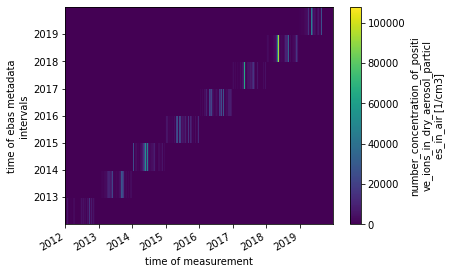

In [51]:
N.plot()

In [62]:
ds_obs

<xarray.Dataset>
Dimensions:                                                  (D: 71, metadata_time: 8, particle_number_size_distribution_amean_qc_flags: 1, particle_number_size_distribution_perc8413_qc_flags: 1, particle_number_size_distribution_prec1587_qc_flags: 1, tbnds: 2, time: 70120)
Coordinates:
  * D                                                        (D) float64 10.0 ... 500.0
  * metadata_time                                            (metadata_time) datetime64[ns] 2012-07-01T23:30:00.050000384 ... 2019-07-02T11:30:00.050000384
  * time                                                     (time) datetime64[ns] 2012-01-01T00:30:00 ... 2019-12-31T22:30:00.049999872
Dimensions without coordinates: particle_number_size_distribution_amean_qc_flags, particle_number_size_distribution_perc8413_qc_flags, particle_number_size_distribution_prec1587_qc_flags, tbnds
Data variables:
    time_bnds                                                (metadata_time, time, tbnds) datetime64[ns] dask.array<chunksize=(8, 8783, 2), meta=np.ndarray>
    metadata_time_bnds                                       (time, metadata_time, tbnds) datetime64[ns] dask.array<chunksize=(8783, 8, 2), meta=np.ndarray>
    particle_number_size_distribution_amean                  (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_amean_qc               (metadata_time, D, particle_number_size_distribution_amean_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_amean_ebasmetadata     (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
    particle_number_size_distribution_prec1587               (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_prec1587_qc            (metadata_time, D, particle_number_size_distribution_prec1587_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_prec1587_ebasmetadata  (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
    particle_number_size_distribution_perc8413               (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_perc8413_qc            (metadata_time, D, particle_number_size_distribution_perc8413_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_perc8413_ebasmetadata  (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
Attributes:
    Conventions:                                   CF-1.8, ACDD-1.3
    featureType:                                   timeSeries
    title:                                         Ground based in situ obser...
    keywords:                                      GUAN, Mount Chacaltaya, nu...
    id:                                            BO0001R.20150101000000.201...
    naming_authority:                              no.nilu.ebas
    project:                                       ACTRIS, GAW-WDCA, GUAN
    acknowledgement:                               Request acknowledgement de...
    license:                                       ACTRIS: http://actris.nilu...
    summary:                                       Ground based in situ obser...
    source:                                        surface observation
    institution:                                   BO01L, Atmospheric Physics...
    processing_level:                              2: final (Physical paramet...
    date_created:                                  2019-09-17T17:55:50 UTC
    date_metadata_modified:                        2019-09-17T17:55:50 UTC
    creator_name:                                  Marcos Andrade, Francesco ...
    creator_type:                                  person
    creator_email

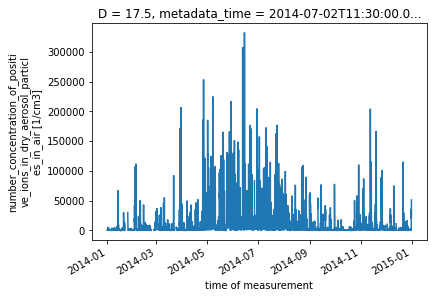

In [64]:
ds_obs['particle_number_size_distribution_amean'].isel(D=10,metadata_time=2 ).plot()

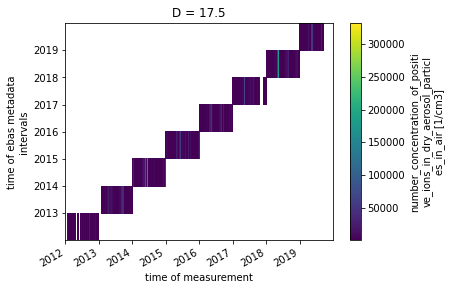

In [61]:
ds_obs['particle_number_size_distribution_amean'].isel(D=10).plot()

In [57]:
N.isel(metadata_time=0)#.plot()

<xarray.DataArray (time: 70120)>
dask.array<getitem, shape=(70120,), dtype=float64, chunksize=(8783,), chunktype=numpy.ndarray>
Coordinates:
    metadata_time  datetime64[ns] 2012-07-01T23:30:00.050000384
  * time           (time) datetime64[ns] 2012-01-01T00:30:00 ... 2019-12-31T22:30:00.049999872
Attributes:
    standard_name:                                 number_concentration_of_po...
    units:                                         1/cm3
    ancillary_variables:                           particle_number_size_distr...
    cell_methods:                                  time: mean
    ebas_revision_date:                            20190917174536
    ebas_version:                                  1
    ebas_version_description:                      initial revision, DMPS_con...
    ebas_statistics:                               arithmetic mean
    ebas_data_level:                               2
    ebas_sample_duration:                          1h
    ebas_orig_time_res:                            5mn
    ebas_station_code:                             BO0001R
    ebas_platform_code:                            BO0001S
    ebas_station_name:                             Mount Chacaltaya
    ebas_station_latitude:                         -16.2000007629
    ebas_station_longitude:                        -68.0999984741
    ebas_station_altitude:                         5320.0 m
    ebas_measuremenet_latitude:                    -16.35
    ebas_measurement_longitude:                    -68.13
    ebas_measurement_altitude:                     5240.0 m
    ebas_measurement_height:                       5.0 m
    ebas_regime:                                   IMG
    ebas_component:                                particle_number_size_distr...
    ebas_unit:                                     1/cm3
    ebas_matrix:                                   aerosol
    ebas_laboratory_code:                          BO01L
    ebas_instrument_type:                          smps
    ebas_instrument_name:                          SMPS_UMSA-LAP_CHACALTAYA_B...
    ebas_instrument_manufacturer:                  TROPOS
    ebas_instrument_model:                         TROPOS-SMPS
    ebas_instrument_serial_number:                 SMPS-CHACALTAYA_BOLIVIA
    ebas_method_ref:                               DE08L_TROPOS_CL_SMPS
    ebas_standard_method:                          SOP=Wiedensohler2012
    ebas_inlet_type:                               Whole-air inlet
    ebas_inlet_description:                        Automatic heater dryer whi...
    ebas_humidity_temperaure_control:              Nafion dryer
    ebas_humidity_temperaure_control_description:  sample dried to below 40% ...
    ebas_volume_std_temperature:                   273.15 K
    ebas_volume_std_pressure:                      1013.25 hPa
    ebas_detection_limit:                          0.0 1/cm3
    ebas_detection_limit_expl:                     Determined only by instrum...
    ebas_measurement_uncertainty:                  10.0 %
    ebas_measurement_uncertainty_expl:             uncertainty range between ...
    ebas_zero_negative_values_code:                Zero possible
    ebas_zero_negative_values:                     Zero values may appear due...
    ebas_organization:                             BO01L, "Atmospheric Physic...
    ebas_framework_acronym:                        ACTRIS, GAW-WDCA, GUAN
    ebas_originator:                               Zaratti, Francesco, fzarat...
    ebas_submitter:                                Velarde, Fernando, fvelard...
    ebas_acknowledgement:                          Request acknowledgement de...
    ebas_comment:                                  None

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


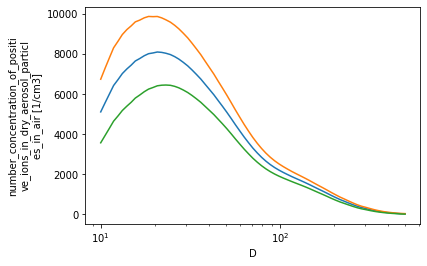

In [35]:
ds_obs['particle_number_size_distribution_amean'].mean('metadata_time').mean('time').plot(xscale='log')

ds_obs['particle_number_size_distribution_perc8413'].mean('metadata_time').mean('time').plot(xscale='log')

ds_obs['particle_number_size_distribution_prec1587'].mean('metadata_time').mean('time').plot(xscale='log')

In [36]:
from sect_sens.data_info import get_nice_name_case

In [37]:
import numpy as np

In [38]:
np.log(10)

2.302585092994046

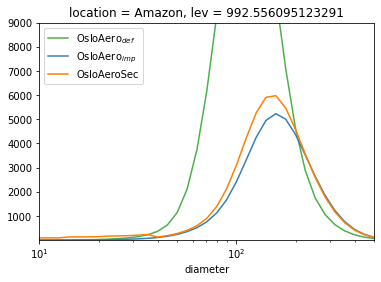

In [39]:
yscale = 'linear'

cndic = dict(noSECTv21_default_dd='OsloAero$_{def}$',
            noSECTv21_ox_ricc_dd = 'OsloAero$_{imp}$')

for case in cases_orig:
    ds= dic_ds[case]
    (np.log(10)*ds['dNdlogD_mod']).isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale=yscale, label=cndic[case], c = get_case_col(cndic[case]))
for case in cases_sec:
    ds= dic_ds[case]
    (np.log(10)*(ds['dNdlogD_sec']+ds['dNdlogD_mod'])).isel(location=0,lev=-1).mean('time').plot(xscale='log', c = get_case_col('OsloAeroSec'),
                                                                                    yscale=yscale, label='OsloAeroSec')
plt.ylim([5,9e3])
plt.xlim([10,500])
#plt.yscale('log')
#ds_obs['sizedist'].mean('Date').plot(xscale='log', c='k', label='OBS: ATTO tower')#x='diameter',robust = True)
plt.legend()

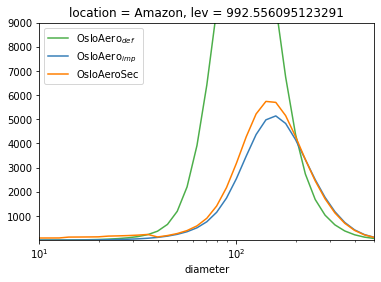

In [40]:
yscale = 'linear'

cndic = dict(noSECTv21_default_dd='OsloAero$_{def}$',
            noSECTv21_ox_ricc_dd = 'OsloAero$_{imp}$')

for case in cases_orig:
    ds= dic_ds[case]
    (np.log(10)*ds['dNdlogD_mod']).isel(location=0,lev=-1).sel(time = slice('2014-01-01','2015-01-01')).mean('time').plot(xscale='log', yscale=yscale, label=cndic[case], c = get_case_col(cndic[case]))
for case in cases_sec:
    ds= dic_ds[case]
    (np.log(10)*(ds['dNdlogD_sec']+ds['dNdlogD_mod'])).isel(location=0,lev=-1).sel(time = slice('2014-01-01','2015-01-01')).mean('time').plot(xscale='log', c = get_case_col('OsloAeroSec'),
                                                                                    yscale=yscale, label='OsloAeroSec')
plt.ylim([5,9e3])
plt.xlim([10,500])
#plt.yscale('log')
#ds_obs['sizedist'].sel(Date = slice('2014-01-01','2015-01-01')).mean('Date').plot(xscale='log', c='k', label='OBS: ATTO tower')#x='diameter',robust = True)
plt.legend()

In [41]:
ds['dNdlogD_mod']

<xarray.DataArray 'dNdlogD_mod' (location: 2, time: 84, lev: 32, diameter: 61)>
[327936 values with dtype=float64]
Coordinates:
  * location  (location) object 'Amazon' 'Chacataya'
  * lev       (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time      (time) datetime64[ns] 2008-01-17 2008-02-15 ... 2014-12-17
  * diameter  (diameter) float64 1.0 1.1 1.3 1.4 1.6 ... 708.0 794.3 891.2 1e+03
Attributes:
    raw_data_path:    /home/ubuntu/mnts/nird/projects/model_output/archive/
    model:            NorESM
    model_name:       NorESM
    case_name:        SECTv21_ctrl_koagD
    case:             SECTv21_ctrl_koagD
    case_name_nice:   OsloAeroSec
    isSectional:      True
    from_time:        2008-01
    to_time:          2014-12
    time_resolution:  month
    history_field:    .h0.
    pressure_coords:  False
    long_name:        dN/dlogD (modal)
    units:            cm-3

In [42]:
ds['dNdlogD_mod'].sel(location='Chacataya',lev=slice(970,1000)).mean('lev').mean('time')

<xarray.DataArray 'dNdlogD_mod' (diameter: 61)>
array([4.15476806e-09, 1.19850333e-08, 7.21545438e-08, 1.56043053e-07,
       6.02657515e-07, 1.90510333e-06, 5.16485472e-06, 1.24052341e-05,
       3.86704385e-05, 1.02189842e-04, 3.07639625e-04, 6.28286329e-04,
       1.75428276e-03, 4.18584116e-03, 8.86220273e-03, 1.93003912e-02,
       4.20450280e-02, 8.98809489e-02, 1.72758774e-01, 3.48692881e-01,
       6.74481720e-01, 1.24966577e+00, 2.31215691e+00, 4.06167771e+00,
       7.22345002e+00, 1.21039940e+01, 1.96819762e+01, 3.21131895e+01,
       5.00999076e+01, 7.68766679e+01, 1.13758612e+02, 1.65214714e+02,
       2.32051626e+02, 3.19039988e+02, 4.25567653e+02, 5.56533014e+02,
       7.15988112e+02, 9.06201196e+02, 1.12954237e+03, 1.38216083e+03,
       1.63940823e+03, 1.85533216e+03, 1.97556109e+03, 1.95899413e+03,
       1.80027978e+03, 1.53758058e+03, 1.22838620e+03, 9.27377884e+02,
       6.69344673e+02, 4.64470522e+02, 3.09570003e+02, 1.97427198e+02,
       1.19786926e+02, 6.88359372e+01, 3.74668385e+01, 1.94103340e+01,
       9.65967273e+00, 4.71503545e+00, 2.31442172e+00, 1.17029248e+00,
       6.19515887e-01])
Coordinates:
    location  <U9 'Chacataya'
  * diameter  (diameter) float64 1.0 1.1 1.3 1.4 1.6 ... 708.0 794.3 891.2 1e+03
Attributes:
    raw_data_path:    /home/ubuntu/mnts/nird/projects/model_output/archive/
    model:            NorESM
    model_name:       NorESM
    case_name:        SECTv21_ctrl_koagD
    case:             SECTv21_ctrl_koagD
    case_name_nice:   OsloAeroSec
    isSectional:      True
    from_time:        2008-01
    to_time:          2014-12
    time_resolution:  month
    history_field:    .h0.
    pressure_coords:  False
    long_name:        dN/dlogD (modal)
    units:            cm-3

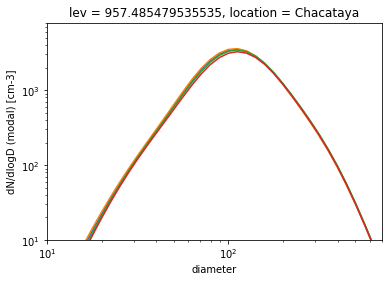

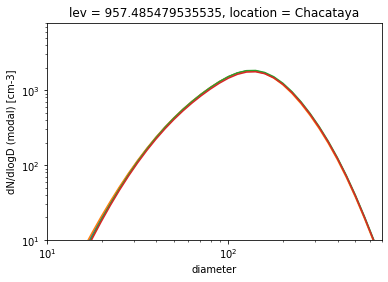

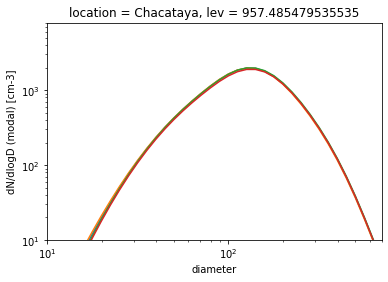

In [43]:
for c in cases:
    ds= dic_ds[c]

    ds['dNdlogD_mod'].sel(location='Chacataya',lev=slice(970,1000)).mean('lev').mean('time').plot()

    ds['dNdlogD_mod'].sel(location='Chacataya',).isel(lev=-1).mean('time').plot()
    ds['dNdlogD_mod'].sel(location='Chacataya',).isel(lev=-2).mean('time').plot()
    ds['dNdlogD_mod'].sel(location='Chacataya',).isel(lev=-3).mean('time').plot()
    plt.xscale('log')
    plt.xlim([10,700])
    plt.ylim([10,8000])
    plt.ylim([10,8000])
    plt.yscale('log')
    plt.show()

In [44]:
def mean_for_comp(ds, isSec=False, vmon = 'dNdlogD_mod', vsec='dNdlogD_sec', p0=970,p1=1000):
    log10 = np.log(10)
    _da = ds[vmon]
    if isSec:
        _da = _da + ds[vsec]
    da_dlog10 = log10*_da
    da_sel = da_dlog10.sel(location='Chacataya',lev = slice(p0,p1)).mean('lev')
    da_mean = da_sel.mean('time')
    return da_mean

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


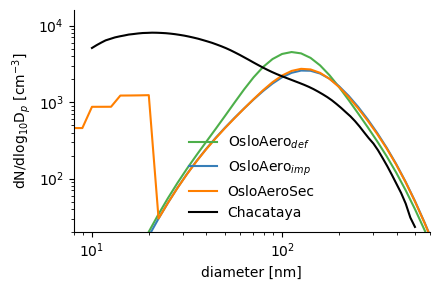

In [45]:
yscale = 'linear'
p0=650
p1=900
cndic = dict(noSECTv21_default_dd='OsloAero$_{def}$',
            noSECTv21_ox_ricc_dd = 'OsloAero$_{imp}$')
f, ax = plt.subplots(figsize=[4.5,3], dpi=100)
for case in cases_orig:
    ds= dic_ds[case]
    da = mean_for_comp(ds, p0=p0,p1=p1)
    da.plot(xscale='log', yscale=yscale, label=cndic[case], c = get_case_col(cndic[case]))
for case in cases_sec:
    ds= dic_ds[case]
    da = mean_for_comp(ds, isSec=True, p0=p0,p1=p1)
    
    da.plot(xscale='log', c = get_case_col('OsloAeroSec'),yscale=yscale, label='OsloAeroSec')
plt.ylim([20,16e3])
plt.xlim([8,600])
plt.yscale('log')
da_obs = ds_obs['particle_number_size_distribution_amean'].mean('metadata_time')
da_obs.mean('time').plot(xscale='log', c='k', label='Chacataya')#x='diameter',robust = True)
#da_obs.groupby(da_obs.time.dt.month).mean().mean('month').plot(xscale='log', c='k', label='ATTO Tower')#x='diameter',robust = True)

plt.legend(frameon=False)
sns.despine(f)
ax.set_ylabel('dN/dlog$_{10}$D$_p$ [cm$^{-3}$]')
ax.set_xlabel('diameter [nm]')
f.tight_layout()

fn = filen_base /'CHC_sizedist_mean2'
f.savefig(fn.with_suffix('.png'))
f.savefig(fn.with_suffix('.pdf'))



In [46]:
ds_obs

<xarray.Dataset>
Dimensions:                                                  (D: 71, metadata_time: 8, particle_number_size_distribution_amean_qc_flags: 1, particle_number_size_distribution_perc8413_qc_flags: 1, particle_number_size_distribution_prec1587_qc_flags: 1, tbnds: 2, time: 70120)
Coordinates:
  * metadata_time                                            (metadata_time) datetime64[ns] 2012-07-01T23:30:00.050000384 ... 2019-07-02T11:30:00.050000384
  * D                                                        (D) float64 10.0 ... 500.0
  * time                                                     (time) datetime64[ns] 2012-01-01T00:30:00 ... 2019-12-31T22:30:00.049999872
Dimensions without coordinates: particle_number_size_distribution_amean_qc_flags, particle_number_size_distribution_perc8413_qc_flags, particle_number_size_distribution_prec1587_qc_flags, tbnds
Data variables:
    time_bnds                                                (metadata_time, time, tbnds) datetime64[ns] dask.array<chunksize=(8, 8783, 2), meta=np.ndarray>
    metadata_time_bnds                                       (time, metadata_time, tbnds) datetime64[ns] dask.array<chunksize=(8783, 8, 2), meta=np.ndarray>
    particle_number_size_distribution_amean                  (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_amean_qc               (metadata_time, D, particle_number_size_distribution_amean_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_amean_ebasmetadata     (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
    particle_number_size_distribution_prec1587               (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_prec1587_qc            (metadata_time, D, particle_number_size_distribution_prec1587_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_prec1587_ebasmetadata  (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
    particle_number_size_distribution_perc8413               (metadata_time, D, time) float64 dask.array<chunksize=(8, 71, 8783), meta=np.ndarray>
    particle_number_size_distribution_perc8413_qc            (metadata_time, D, particle_number_size_distribution_perc8413_qc_flags, time) float64 dask.array<chunksize=(8, 71, 1, 8783), meta=np.ndarray>
    particle_number_size_distribution_perc8413_ebasmetadata  (time, D, metadata_time) object dask.array<chunksize=(8783, 71, 8), meta=np.ndarray>
Attributes:
    Conventions:                                   CF-1.8, ACDD-1.3
    featureType:                                   timeSeries
    title:                                         Ground based in situ obser...
    keywords:                                      GUAN, Mount Chacaltaya, nu...
    id:                                            BO0001R.20150101000000.201...
    naming_authority:                              no.nilu.ebas
    project:                                       ACTRIS, GAW-WDCA, GUAN
    acknowledgement:                               Request acknowledgement de...
    license:                                       ACTRIS: http://actris.nilu...
    summary:                                       Ground based in situ obser...
    source:                                        surface observation
    institution:                                   BO01L, Atmospheric Physics...
    processing_level:                              2: final (Physical paramet...
    date_created:                                  2019-09-17T17:55:50 UTC
    date_metadata_modified:                        2019-09-17T17:55:50 UTC
    creator_name:                                  Marcos Andrade, Francesco ...
    creator_type:                                  person
    creator_email

In [47]:
def mean_for_comp_month(ds, isSec=False, vmon = 'dNdlogD_mod', vsec='dNdlogD_sec', p0=650, p1=900):
    log10 = np.log(10)
    _da = ds[vmon]
    if isSec:
        _da = _da + ds[vsec]
    da_dlog10 = log10*_da
    da_sel = da_dlog10.isel(location=1).sel(lev = slice(p0,p1)).mean('lev')
    da_mean = da_sel.groupby(da_sel.time.dt.month).mean()
    return da_mean

In [48]:
from matplotlib.colors import LogNorm

/persistent01/miniconda3/envs/env_sec_v2/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


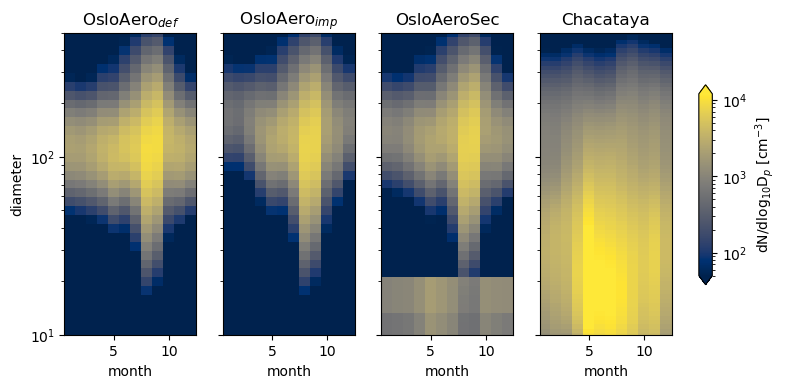

In [49]:

p0=650
p1=900
yscale = 'log'
xscale='linear'
f,axs = plt.subplots(1,4, figsize=[9 ,4], sharex=True, sharey=True, dpi=100)
cndic = dict(noSECTv21_default_dd='OsloAero$_{def}$',
            noSECTv21_ox_ricc_dd = 'OsloAero$_{imp}$',
            SECTv21_ctrl_koagD = 'OsloAeroSec')
norm = LogNorm(vmin=50, vmax=12000)

plt_sett = dict(
    norm=norm,
    cmap='cividis',
    yscale=yscale,
    xscale=xscale,
    ylim=[10,500],
    add_colorbar=False,
    rasterized=True
)


for case,ax in zip(cases_orig,axs):
    ds= dic_ds[case]
    da = mean_for_comp_month(ds, p0=p0, p1=p1)
    da.plot(x='month',**plt_sett,ax=ax)#, label=cndic[case], c = get_case_col(cndic[case]))
    ax.set_title(cndic[case])
for case, ax in zip(cases_sec, axs[len(cases_orig):]):
    ds= dic_ds[case]
    da = mean_for_comp_month(ds, isSec=True, p0=p0, p1=p1)
    da.plot(x='month',**plt_sett,ax=ax)#, label=cndic[case], c = get_case_col(cndic[case]))
    ax.set_title(cndic[case])

ax = axs[-1]
da_obs = ds_obs['particle_number_size_distribution_amean'].mean('metadata_time')
#da_obs.mean('time').plot(xscale='log', c='k', label='ATTO Tower')#x='diameter',robust = True)
im = da_obs.groupby(da_obs.time.dt.month).mean().plot(x='month',**plt_sett, ax = ax)#x='diameter',robust = True)


for ax in axs[1:].flatten():
    ax.set_ylabel('')
#for ax in axs_ba[-1,:].flatten():
#    ax.set_xlabel('Latitude [$^\circ$ N]')
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.83, 0.25, 0.015, 0.5])

cb = f.colorbar(im, cax=cbar_ax, extend = 'both', label= 'dN/dlog$_{10}$D$_p$ [cm$^{-3}$]' )
ax.set_title('Chacataya')

fn = filen_base /'CHC_sizedist_month'
f.savefig(fn.with_suffix('.png'), bbox_extra_artists=(cb,))
f.savefig(fn.with_suffix('.pdf'), bbox_extra_artists=(cb,))
plt.show()

## Extra: 

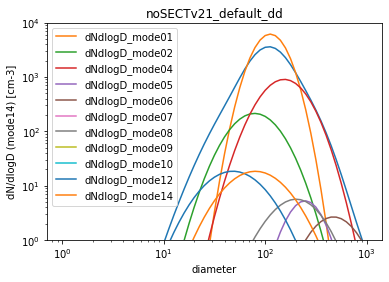

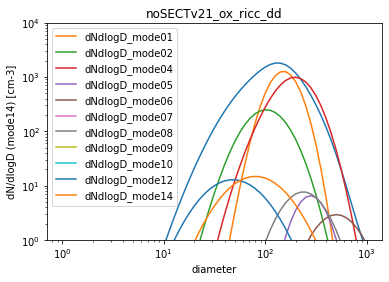

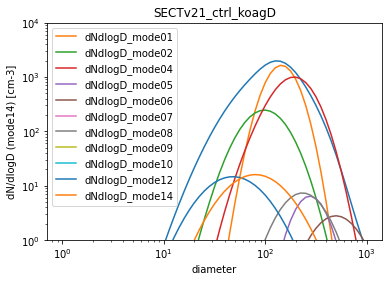

In [50]:
for case in cases_pd:
    ds = dic_ds[case]
    ds['dNdlogD_mod'].isel(location=1,lev=-1).mean('time').plot(xscale='log', yscale='log')

    for var in [
        'dNdlogD_mode01',
        'dNdlogD_mode02',
        'dNdlogD_mode04',
        'dNdlogD_mode05',
        'dNdlogD_mode06',
        'dNdlogD_mode07',
        'dNdlogD_mode08',
        'dNdlogD_mode09',
        'dNdlogD_mode10',
        'dNdlogD_mode12',
        'dNdlogD_mode14'
    ]:
        ds[var].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log', label=var)
#ds['dNdlogD_mode02'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
#ds['dNdlogD_mode04'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
    plt.legend()
    #plt.yscale('linear')
    plt.ylim([10e-1,1e4])
    plt.title(case)
    plt.show()

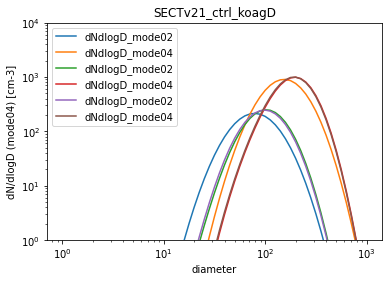

In [51]:
for case in cases_pd:
    ds = dic_ds[case]
    #ds['dNdlogD_mod'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')

    for var in [#'dNdlogD_mode01',
                'dNdlogD_mode02','dNdlogD_mode04',
            #'dNdlogD_mode05','dNdlogD_mode06','dNdlogD_mode07',
            #'dNdlogD_mode08',
            #    'dNdlogD_mode09','dNdlogD_mode10'
           #'dNdlogD_mode12','dNdlogD_mode14'
    ]:
        ds[var].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log', label=var)
#ds['dNdlogD_mode02'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
#ds['dNdlogD_mode04'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
    plt.legend()
    #plt.yscale('linear')
    plt.ylim([10e-1,1e4])
    plt.title(case)
    #plt.show()

(1.0, 700.0)

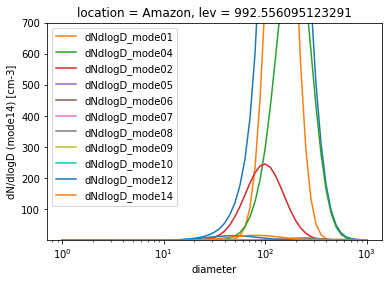

In [52]:
ds['dNdlogD_mod'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')

for var in ['dNdlogD_mode01','dNdlogD_mode04','dNdlogD_mode02',
            'dNdlogD_mode05','dNdlogD_mode06','dNdlogD_mode07',
            'dNdlogD_mode08','dNdlogD_mode09','dNdlogD_mode10'
           ,'dNdlogD_mode12','dNdlogD_mode14']:
    ds[var].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log', label=var)
#ds['dNdlogD_mode02'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
#ds['dNdlogD_mode04'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
plt.legend()
plt.yscale('linear')
plt.ylim([10e-1,7e2])

(1.0, 100000.0)

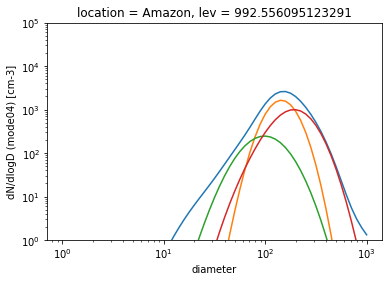

In [53]:
ds['dNdlogD_mod'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
ds['dNdlogD_mode01'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
ds['dNdlogD_mode02'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
ds['dNdlogD_mode04'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
plt.ylim([10e-1,10e4])

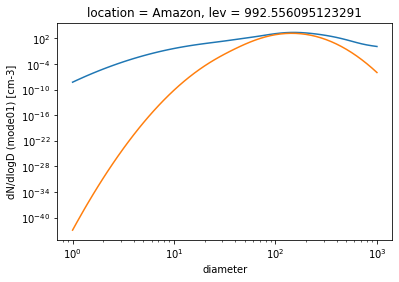

In [55]:
ds['dNdlogD_mod'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')
ds['dNdlogD_mode01'].isel(location=0,lev=-1).mean('time').plot(xscale='log', yscale='log')

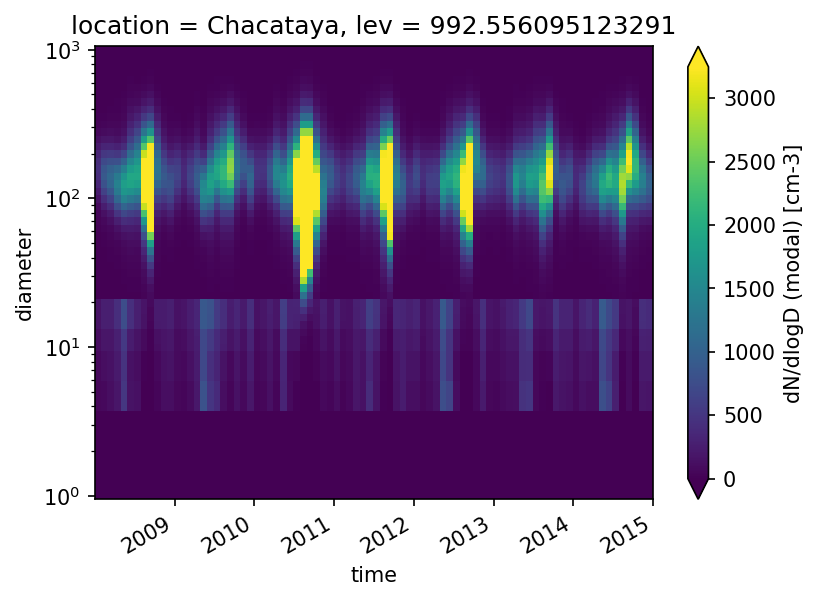

In [62]:
f, ax = plt.subplots(dpi=150)
(ds['dNdlogD_mod']+ds['dNdlogD_sec']).sel(location='Chacataya').isel(lev=-1).plot(yscale='log', x='time', robust=True)